## **1.1. Change the Runtime type**
---


<font size = 4>Go to **Runtime -> Change the Runtime type**

<font size = 4>**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

<font size = 4>**Accelator: GPU** *(Graphics processing unit)*


In [1]:
#@markdown ##Run this cell to check if you have GPU access
%tensorflow_version 1.x

import tensorflow as tf
if tf.test.gpu_device_name()=='':
  print('You do not have GPU access.') 
  print('Did you change your runtime ?') 
  print('If the runtime settings are correct then Google did not allocate GPU to your session')
  print('Expect slow performance. To access GPU try reconnecting later')

else:
  print('You have GPU access')

from tensorflow.python.client import device_lib 
device_lib.list_local_devices()


TensorFlow 1.x selected.
You have GPU access


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7600705954451980844, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5000670314752572990
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17764088417310523075
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6205775913950372563
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

## **1.2. Mount your Google Drive**
---
<font size = 4> To use this notebook on the data present in your Google Drive, you need to mount your Google Drive to this notebook.

<font size = 4> Play the cell below to mount your Google Drive and follow the link. In the new browser window, select your drive and select 'Allow', copy the code, paste into the cell and press enter. This will give Colab access to the data on the drive. 

<font size = 4> Once this is done, your data are available in the **Files** tab on the top left of notebook.

In [2]:
#@markdown ##Run this cell to connect your Google Drive to Colab

#@markdown * Click on the URL. 

#@markdown * Sign in your Google Account. 

#@markdown * Copy the authorization code. 

#@markdown * Enter the authorization code. 

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 

#mounts user's Google Drive to Google Colab.

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# **2. Install CARE and Dependencies**
---


In [1]:
#@markdown ##Install CARE and dependencies

#Libraries contains information of certain topics. 
#For example the tifffile library contains information on how to handle tif-files.

#Here, we install libraries which are not already included in Colab.
!pip install tifffile # contains tools to operate tiff-files
!pip install csbdeep  # contains tools for restoration of fluorescence microcopy images (Content-aware Image Restoration, CARE). It uses Keras and Tensorflow.

#Here, we import and enable Tensorflow 1 instead of Tensorflow 2.
%tensorflow_version 1.x
import tensorflow
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(tensorflow.__version__)
print("Tensorflow enabled.")

#Here, we import all libraries necessary for this notebook.
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from tifffile import imread, imsave
from csbdeep.utils import download_and_extract_zip_file, plot_some, axes_dict, plot_history, Path, download_and_extract_zip_file
from csbdeep.data import RawData, create_patches 
from csbdeep.io import load_training_data, save_tiff_imagej_compatible
from csbdeep.models import Config, CARE
from csbdeep import data
from pathlib import Path
import os, random
import shutil
import pandas as pd
import csv

!pip install memory_profiler
%load_ext memory_profiler

print("Depencies installed and imported.")

     |████████████████████████████████| 133kB 2.7MB/s 
     |████████████████████████████████| 18.1MB 1.3MB/s 
     |████████████████████████████████| 71kB 2.1MB/s 
TensorFlow 1.x selected.
Instructions for updating:
non-resource variables are not supported in the long term
1.15.2
Tensorflow enabled.


Using TensorFlow backend.


  Created wheel for memory-profiler: filename=memory_profiler-0.57.0-cp36-none-any.whl size=28992 sha256=f00c617fc514aff15ede80d5f9f020af65d7061f9bc0adf9e4f502c85f690b60
  Stored in directory: /root/.cache/pip/wheels/74/20/b5/20964ef97be73d2c3a695c9cad7bccd96d1e3e737a8163861f
Successfully built memory-profiler
Depencies installed and imported.


# **3. Select your paths and parameters**

---

<font size = 4>The code below allows the user to enter the paths to where the training data is and to define the training parameters.


<font size = 5> **Paths for training, predictions and results**

<font size = 4>**`Training_source:`, `Training_target`:** These are the paths to your folders containing the Training_source (Low SNR images) and Training_target (High SNR images or ground truth) training data respecively. To find the paths of the folders containing the respective datasets, go to your Files on the left of the notebook, navigate to the folder containing your files and copy the path by right-clicking on the folder, **Copy path** and pasting it into the right box below.

<font size = 4>**`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.

<font size = 4>**`model_path`**: Enter the path where your model will be saved once trained (for instance your result folder).

<font size = 4>**`visual_validation_after_training`**: If you select this option, a random image pair will be set aside from your training set and will be used to display a predicted image of the trained network next to the input and the ground-truth. This can aid in visually assessing the performance of your network after training. **Note: Your training set size will decrease by 1 if you select this option.**

<font size = 5>**Training Parameters**

<font size = 4>**`number_of_epochs`:**Input how many epochs (rounds) the network will be trained. Preliminary results can already be observed after a few (10-30) epochs, but a full training should run for 100-300 epochs. Evaluate the performance after training (see 4.3.). **Default value: 50**

<font size = 4>**`patch_size`:** CARE divides the image into patches for training. Input the size of the patches (length of a side). The value should be smaller than the dimensions of the image and divisible by 8. **Default value: 80**

<font size = 4>**`number_of_patches`:** Input the number of the patches per image. Increasing the number of patches allows for larger training datasets. **Default value: 100** 

<font size = 4>**Decreasing the patch size or increasing the number of patches may improve the training but may also increase the training time.**

<font size = 5>**Advanced Parameters - experienced users only**

<font size = 4>**`number_of_steps`:** Define the number of training steps by epoch. By default this parameter is calculated so that each patch is seen at least once per epoch. **Default value: Number of patch / batch_size**

<font size =4>**`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 64**

<font size = 4>**`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during training. **Default value: 10** 

Default advanced parameters enabled
Loaded Input images (number, width, length) = (499, 512, 1024)
Loaded Output images (number, width, length) = (499, 512, 1024)
Parameters initiated.


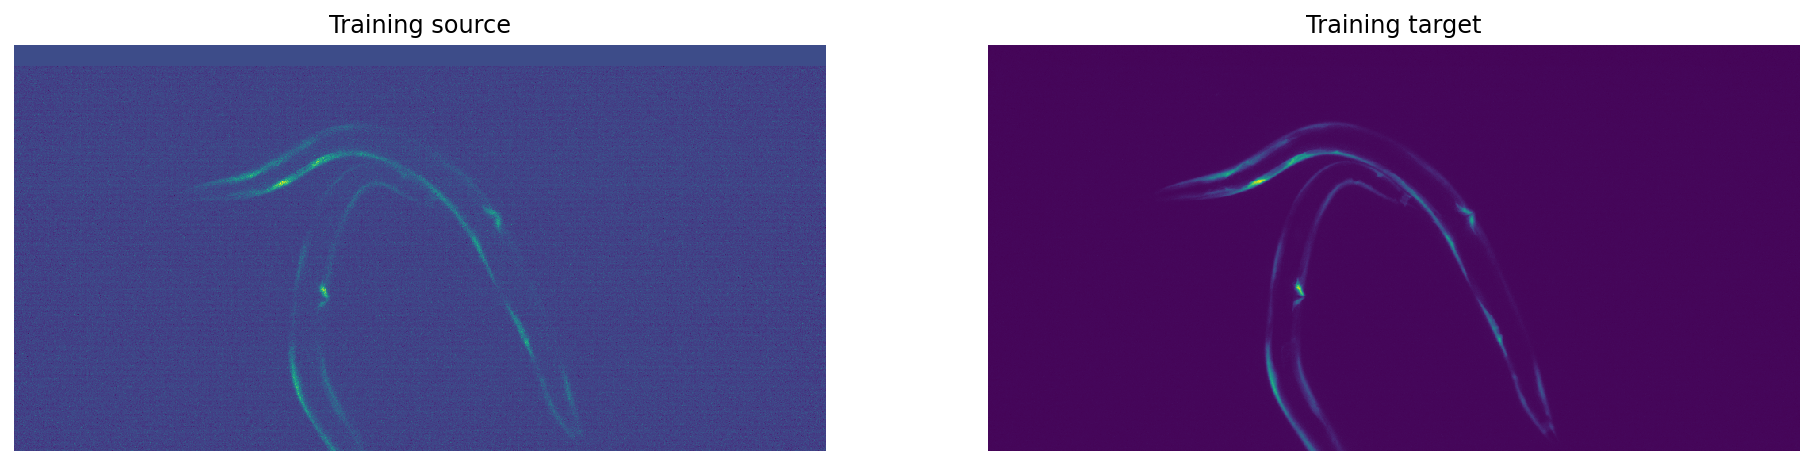

In [3]:
#@markdown ###Path to training images:

# base folder of GT and low images
#base = "/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/CARE 2D/Nucleus_datasets/train"
base = "/content/"
training_data = base+"/my_training_data.npz"

# low SNR images
# low = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Training datasets/CARE (2D)/Training - Low SNR images" #@param {type:"string"}
Training_source = "/content/gdrive/My Drive/cloud_colab/CARE (2D)/Train/Low" #@param {type:"string"}


#Input_data_folder = Training_source
InputFile = Training_source+"/*.tif"

# Ground truth images
# GT = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Training datasets/CARE (2D)/Training - High SNR images" #@param {type:"string"}
Training_target = "/content/gdrive/My Drive/cloud_colab/CARE (2D)/Train/High" #@param {type:"string"}

#Output_data_folder = Training_target
OutputFile = Training_target+"/*.tif"

# model name and path
#@markdown ###Name of the model and path to model folder:
model_name = "Model_Try1" #@param {type:"string"}
model_path = "/content/drive/My Drive/cloud_colab/CARE_WORMS1/models" #@param {type:"string"}

#@markdown ####Use one image of the training set for visual assessment of the training:
Visual_validation_after_training = True #@param {type:"boolean"}


# other parameters for training.
#@markdown ###Training Parameters
#@markdown Number of epochs:

number_of_epochs =  100#@param {type:"number"}

#@markdown Patch size (pixels) and number
patch_size =  64#@param {type:"number"} # in pixels

number_of_patches =   10#@param {type:"number"}


#@markdown ###Advanced Parameters

Use_Default_Advanced_Parameters = True #@param {type:"boolean"}
#@markdown ###If not, please input:

number_of_steps =  300 #@param {type:"number"}
batch_size =  32#@param {type:"number"}
percentage_validation =  15 #@param {type:"number"}


if (Use_Default_Advanced_Parameters): 
  print("Default advanced parameters enabled")
  batch_size = 64
  percentage_validation = 10

percentage = percentage_validation/100

#here we check that no model with the same name already exist, if so delete
if os.path.exists(model_path+'/'+model_name):
  shutil.rmtree(model_path+'/'+model_name)


# The shape of the images.
x = imread(InputFile)
y = imread(OutputFile)

print('Loaded Input images (number, width, length) =', x.shape)
print('Loaded Output images (number, width, length) =', y.shape)
print("Parameters initiated.")

# This will display a randomly chosen dataset input and output
random_choice = random.choice(os.listdir(Training_source))
x = imread(Training_source+"/"+random_choice)

os.chdir(Training_target)
y = imread(Training_target+"/"+random_choice)

f=plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(x, interpolation='nearest')
plt.title('Training source')
plt.axis('off');

plt.subplot(1,2,2)
plt.imshow(y, interpolation='nearest')
plt.title('Training target')
plt.axis('off');

#protection for next cell
if (Visual_validation_after_training):
  Cell_executed = 0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **4. Train the network**
---

## **4.1. Prepare the training data and model for training**
---
<font size = 4>Here, we use the information from 3. to build the model and convert the training data into a suitable format for training.

  498 raw images x    1 transformations   =   498 images
  498 images     x   10 patches per image =  4980 patches in total
Input data:
/content/: target='/content/gdrive/My Drive/cloud_colab/CARE (2D)/Train/High', sources=['/content/gdrive/My Drive/cloud_colab/CARE (2D)/Train/Low'], axes='CYX', pattern='*.tif*'
Transformations:
1 x Identity
Patch size:
64 x 64


100%|██████████| 498/498 [00:14<00:00, 33.31it/s]


Creating 2D training dataset
number of training images:	 4482
number of validation images:	 498
image size (2D):		 (64, 64)
axes:				 SYXC
channels in / out:		 1 / 1
peak memory: 1367.17 MiB, increment: 0.02 MiB
71
Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=64, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=71, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=3, unet_n_first=32, unet_residual=True)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



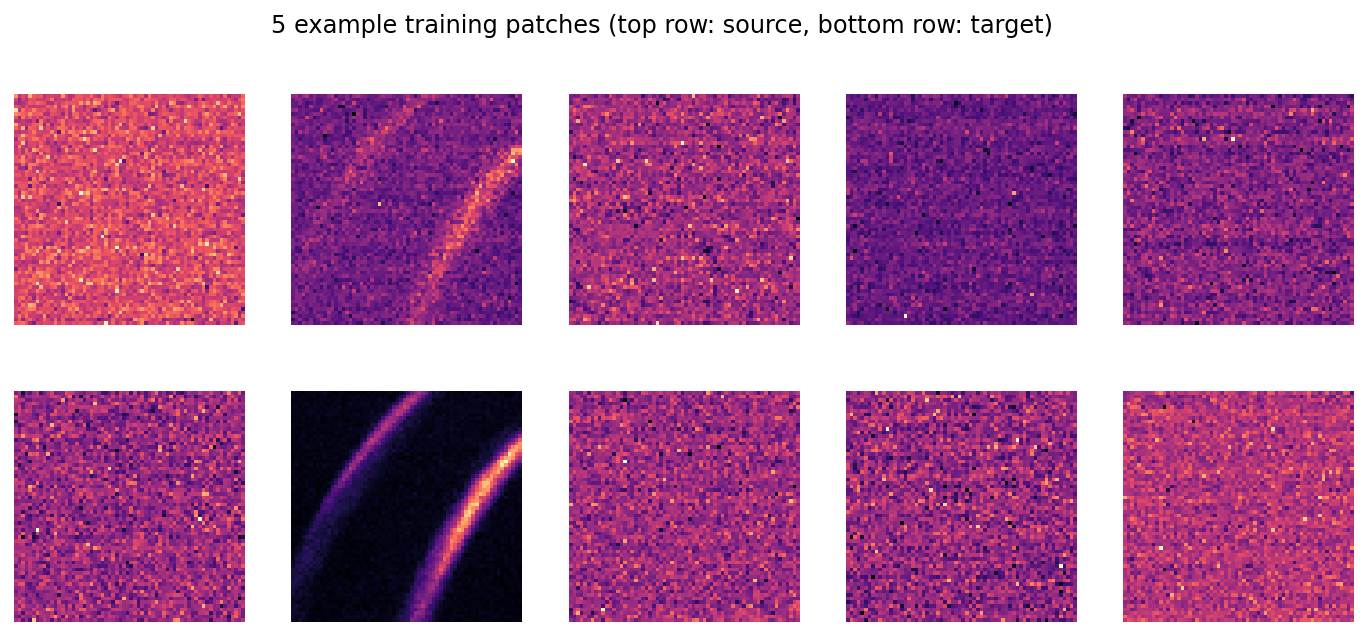

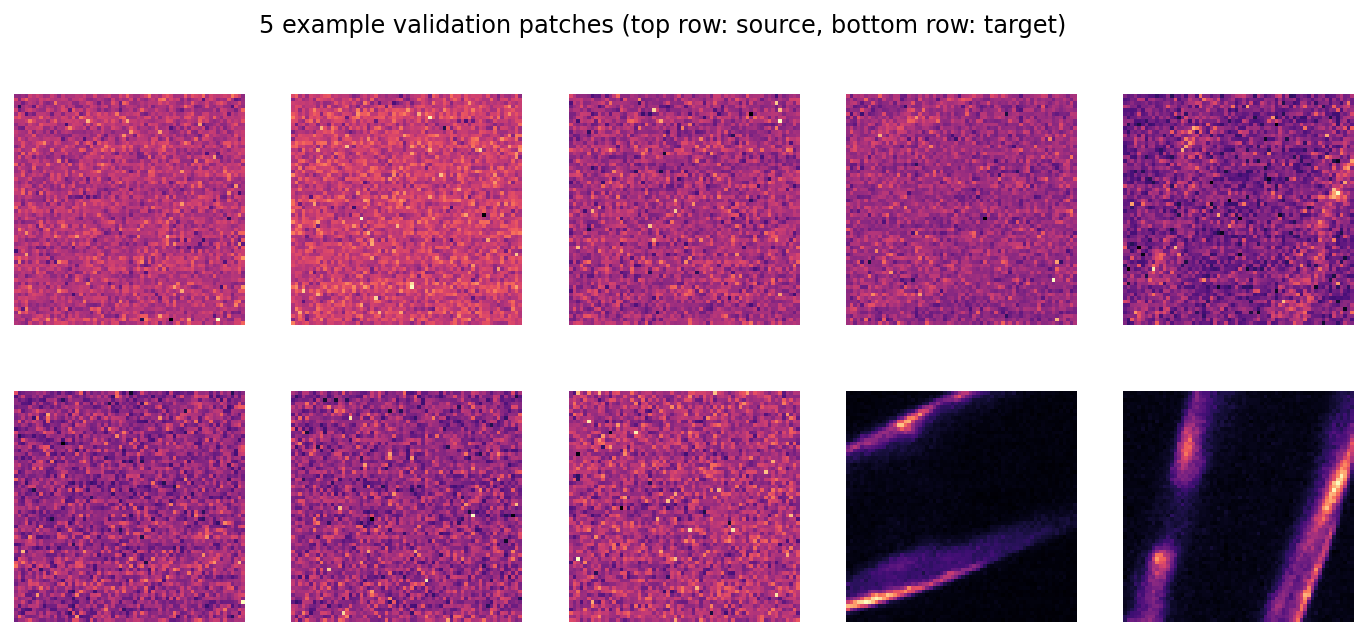

In [4]:
#@markdown ##Create the model and dataset objects
# The code in this cell is inspired by that from the authors' repository (https://github.com/CSBDeep/CSBDeep).

if (Visual_validation_after_training):
  if Cell_executed == 0 :

#Create a temporary file folder for immediate assessment of training results:
#If the folder still exists, delete it
    if os.path.exists(Training_source+"/temp"):
      shutil.rmtree(Training_source+"/temp")

    if os.path.exists(Training_target+"/temp"):
      shutil.rmtree(Training_target+"/temp")

    if os.path.exists(model_path+"/temp"):
      shutil.rmtree(model_path+"/temp")

#Create directories to move files temporarily into for assessment
    os.makedirs(Training_source+"/temp")
    os.makedirs(Training_target+"/temp")
    os.makedirs(model_path+"/temp")
    #list_source = os.listdir(os.path.join(Training_source))
    #list_target = os.listdir(os.path.join(Training_target))
#Move files into the temporary source and target directories:
    shutil.move(Training_source+"/"+random_choice, Training_source+'/temp/'+random_choice)
    shutil.move(Training_target+"/"+random_choice, Training_target+'/temp/'+random_choice)

# RawData Object

# This object holds the image pairs (GT and low), ensuring that CARE compares corresponding images.
# This file is saved in .npz format and later called when loading the trainig data.

raw_data = data.RawData.from_folder(
    basepath=base,
    source_dirs=[Training_source], 
    target_dir=Training_target, 
    axes='CYX', 
    pattern='*.tif*')

X, Y, XY_axes = data.create_patches(
    raw_data, 
    patch_filter=None, 
    patch_size=(patch_size,patch_size), 
    n_patches_per_image=number_of_patches)

print ('Creating 2D training dataset')
training_path = model_path+"/rawdata"
rawdata1 = training_path+".npz"
np.savez(training_path,X=X, Y=Y, axes=XY_axes)

# Load Training Data
(X,Y), (X_val,Y_val), axes = load_training_data(rawdata1, validation_split=percentage, verbose=True)
c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

%memit 

#plot of training patches.
plt.figure(figsize=(12,5))
plot_some(X[:5],Y[:5])
plt.suptitle('5 example training patches (top row: source, bottom row: target)');

#plot of validation patches
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');


#Here we automatically define number_of_step in function of training data and batch size
if (Use_Default_Advanced_Parameters): 
  number_of_steps= int(X.shape[0]/batch_size)+1

print(number_of_steps)

#Here we create the configuration file

config = Config(axes, n_channel_in, n_channel_out, probabilistic=False, train_steps_per_epoch=number_of_steps, train_epochs=number_of_epochs, unet_kern_size=5, unet_n_depth=3, train_batch_size=batch_size, train_learning_rate=0.0004)

print(config)
vars(config)

# Compile the CARE model for network training
model_training= CARE(config, model_name, basedir=model_path)


if (Visual_validation_after_training):
  Cell_executed = 1

## **4.2. Train the network**
---
<font size = 4>When playing the cell below you should see updates after each epoch (round). Network training can take some time.

<font size = 4>* **CRITICAL NOTE:** Google Colab has a time limit for processing (to prevent using GPU power for datamining). Training time must be less than 12 hours! If training takes longer than 12 hours, please decrease the number of epochs or number of patches.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/100
71/71 [==============================] - 25s 356ms/step - loss: 0.1001 - mse: 0.0277 - mae: 0.0999 - val_loss: 0.0453 - val_mse: 0.0127 - val_mae: 0.0453

Epoch 2/100
71/71 [==============================] - 16s 223ms/step - loss: 0.0408 - mse: 0.0136 - mae: 0.0409 - val_loss: 0.0326 - val_mse: 0.0118 - val_mae: 0.0326
Epoch 3/100
71/71 [==============================] - 17s 234ms/step - loss: 0.0358 - mse: 0.0131 - mae: 0.0362 - val_loss: 0.0308 - val_mse: 0.0116 - val_mae: 0.0308
Epoch 4/100
71/71 [==============================] - 16s 224ms/step - loss: 0.0330 - mse: 0.0129 - mae: 0.0333 - val_loss: 0.0292 - v

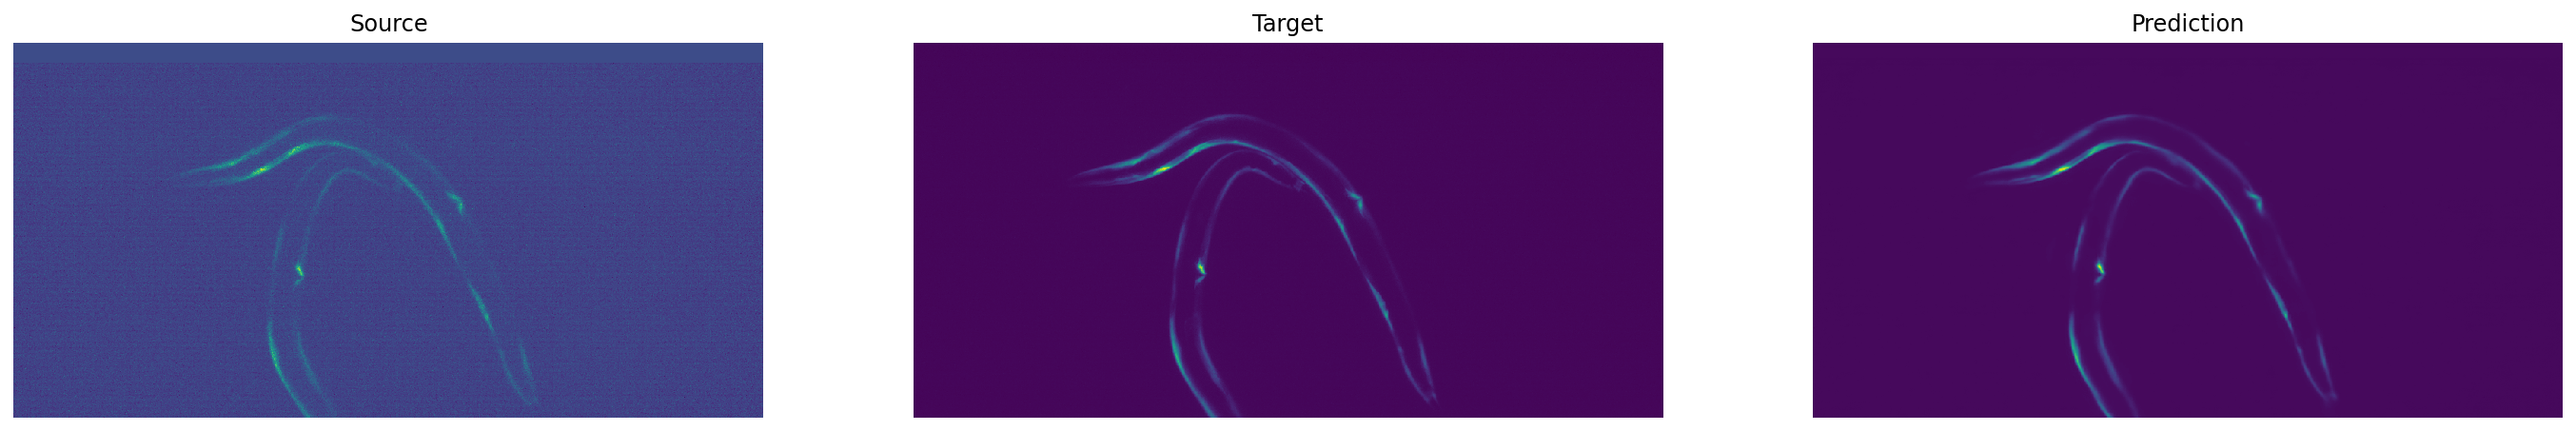

In [5]:
import time
start = time.time()

#@markdown ##Start Training

# Start Training
history = model_training.train(X,Y, validation_data=(X_val,Y_val))

print("Training, done.")


if (Visual_validation_after_training):
  if Cell_executed == 1:
#Here we predict one image
    validation_image = imread(Training_source+"/temp/"+random_choice)
    validation_test = model_training.predict(validation_image, axes='YX')
    os.chdir(model_path+"/temp/")
    imsave(random_choice+"_predicted.tif",validation_test)
#Source
    I = imread(Training_source+"/temp/"+random_choice)
#Target
    J = imread(Training_target+"/temp/"+random_choice)
#Prediction
    K = imread(model_path+"/temp/"+random_choice+"_predicted.tif")
#Make a plot
    f=plt.figure(figsize=(24,12))
    plt.subplot(1,3,1)
    plt.imshow(I, interpolation='nearest')
    plt.title('Source')
    plt.axis('off');

    plt.subplot(1,3,2)
    plt.imshow(J, interpolation='nearest')
    plt.title('Target')
    plt.axis('off');

    plt.subplot(1,3,3)
    plt.imshow(K, interpolation='nearest')
    plt.title('Prediction')
    plt.axis('off');

#Move the temporary files back to their original folders
    shutil.move(Training_source+'/temp/'+random_choice, Training_source+"/"+random_choice)
    shutil.move(Training_target+'/temp/'+random_choice, Training_target+"/"+random_choice)

#Delete the temporary folder
    shutil.rmtree(Training_target+'/temp')
    shutil.rmtree(Training_source+'/temp')

#protection against removing data
  Cell_executed = 0


# Displaying the time elapsed for training
dt = time.time() - start
min, sec = divmod(dt, 60) 
hour, min = divmod(min, 60) 
print("Time elapsed:",hour, "hour(s)",min,"min(s)",round(sec),"sec(s)")


## **4.3. Evaluate the training**
---

<font size = 4>It is good practice to evaluate the training progress by comparing the training loss with the validation loss. The latter is a metric which shows how well the network performs on a subset of unseen data which is set aside from the training dataset. For more information on this, see for example [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

<font size = 4>**Loss** <code>(loss)</code> describes an error value after each epoch for the difference between the model's prediction and its ground-truth ('GT') target.

<font size = 4>**Validation loss** <code>(val_loss)</code> describes the same error value between the model's prediction on a validation image (taken from 'low') and compared to it's target (from 'GT').

<font size = 4>During training both values should decrease before reaching a minimal value which does not decrease further even after more training. Comparing the development of the validation loss with the training loss can give insights into the model's performance.

<font size = 4>Decreasing **loss** and **validation loss** indicates that training is still necessary and increasing the `number_of_epochs` is recommended. Note that the curves can look flat towards the right side, just because of the y-axis scaling. The network has reached convergence once the curves flatten out. After this point no further training is required. If the **validation loss** suddenly increases again an the **loss** simultaneously goes towards zero, it means that the network is overfitting to the training data. In other words the network is remembering the exact patterns from the training data and no longer generalizes well to unseen data. In this case the training dataset has to be increased.

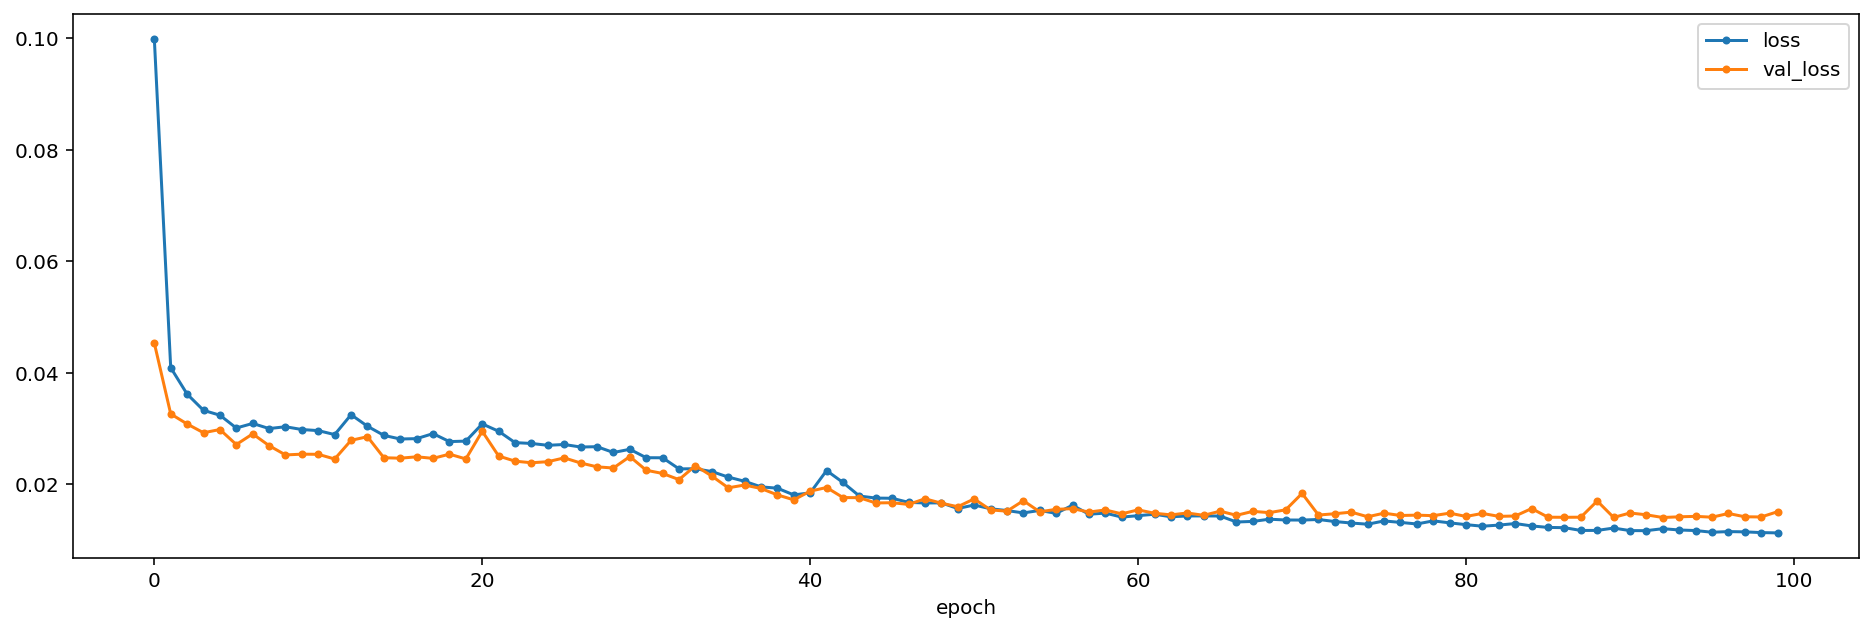

In [6]:
#@markdown ##Play the cell to show a plot of training errors vs. epoch number

# Create figure framesize
errorfigure = plt.figure(figsize=(16,5))

# Choose the values you wish to compare. 
# For example, If you wish to see another values, just replace 'loss' to 'dist_loss'
plot_history(history,['loss','val_loss']); 
errorfigure.savefig(model_path+'/training evaluation.tif') 

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# The figure is saved into content/ as training evaluation.csv (refresh the Files if needed). 
RESULTS = model_path+'/training evaluation.csv'
with open(RESULTS, 'w') as f:
    for key in hist_df.keys():
        f.write("%s,%s\n"%(key,hist_df[key]))

## **4.4. Export model to be used with *CSBDeep Fiji plugins* and *KNIME* workflows (Experimental !!!)**
---

<font size = 4>This allows you to save the trained model in a format where it can be used in the CSBDeep Fiji Plugin. See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

<font size = 4>After saving the model to your drive, download the .zip file from your google drive. Do this from your Google Drive and not in the colab interface as this takes very long.

In [0]:
#@markdown ##Play this cell to save a Fiji-compatible model to Google Drive.

# exports the trained model to Fiji.
# The code is from (https://github.com/CSBDeep/CSBDeep).
model_training.export_TF()

##**4.5. Download your model(s) from Google Drive**
---
<font size = 4>The model and its parameters have been saved to your **model_path** on your Google Drive. It is however wise to download the folder as all data can be erased at the next training if using the same folder.

# **5. Use the network**

---

<font size = 4>In this section the unseen data is processed using the trained model (in section 4). First, your unseen images are uploaded and prepared for prediction. After that your trained model from section 4 is activated and finally saved into your Google Drive.

## **5.1. Generate prediction from test dataset**
---

<font size = 4>The current trained model (from section 4.2) can now be used to process images. If you want to use an older model, untick the **Use_the_current_trained_model** box and enter the name and path of the model to use. Predicted output images are saved in your **Result_folder** folder as restored image stacks (ImageJ-compatible TIFF images).

<font size = 4>**`Test_data_folder`:** This folder should contain the images that you want to use your trained network on for processing.

<font size = 4>**`Result_folder`:** This folder will contain the predicted output images.

Using current trained network
Loading network weights from 'weights_best.h5'.
Images saved into folder: /content/gdrive/My Drive/cloud_colab/CARE (2D)/Test/Result


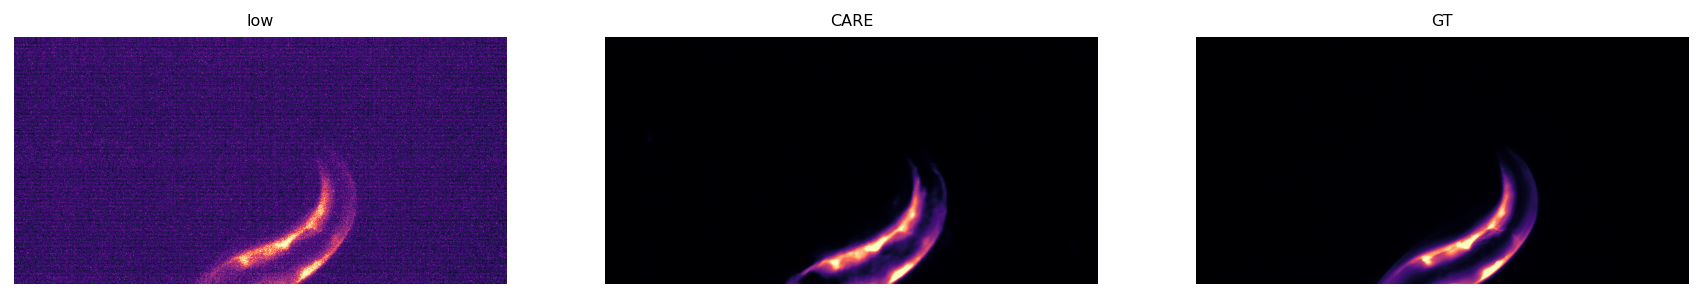

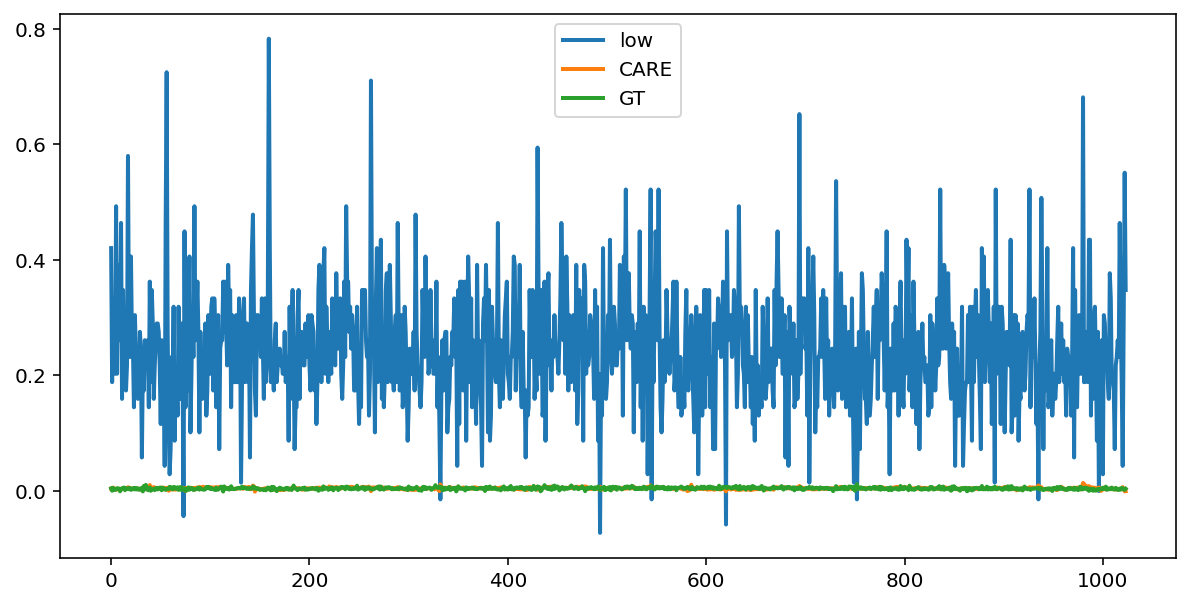

In [20]:
from csbdeep.utils import normalize
#Activate the pretrained model. 
#model_training = CARE(config=None, name=model_name, basedir=model_path)

#@markdown ### Provide the path to your dataset and to the folder where the predictions are saved, then play the cell to predict outputs from your unseen images.

Test_data_folder = "/content/gdrive/My Drive/cloud_colab/CARE (2D)/Test/Low" #@param {type:"string"}
Result_folder = "/content/gdrive/My Drive/cloud_colab/CARE (2D)/Test/Result" #@param {type:"string"}
Target_folder = "/content/gdrive/My Drive/cloud_colab/CARE (2D)/Test/GT" #@param {type:"string"}

# model name and path
#@markdown ###Do you want to use the current trained model?
Use_the_current_trained_model = True #@param {type:"boolean"}

#@markdown ###If not, provide the name of the model and path to model folder:
#@markdown #####During training, the model files are automatically saved inside a folder named after the parameter 'model_name' (see section 3). Provide the name of this folder as 'inference_model_name' and the path to its parent folder in 'inference_model_path'. 

inference_model_name = "" #@param {type:"string"}
inference_model_path = "" #@param {type:"string"}

if (Use_the_current_trained_model): 
  print("Using current trained network")
  inference_model_name = model_name
  inference_model_path = model_path
#training_path = model_path+"/"


#Activate the pretrained model. 
model_training = CARE(config=None, name=inference_model_name, basedir=inference_model_path)


# creates a loop, creating filenames and saving them
for filename in os.listdir(Test_data_folder):
  img = imread(os.path.join(Test_data_folder,filename))
  y = imread(os.path.join(Target_folder,filename))
  restored = model_training.predict(img, axes='YX')
  plt.figure(figsize=(15,10))
  plot_some(np.stack([img,restored,y]),
          title_list=[['low','CARE','GT']], 
          pmin=2,pmax=99.8);

  plt.figure(figsize=(10,5))
  for _x,_name in zip((img,restored,y),('low','CARE','GT')):
    plt.plot(normalize(_x,1,99.7)[180], label = _name, lw = 2)
    plt.legend();
  os.chdir(Result_folder)
  imsave(filename,restored)

  

print("Images saved into folder:", Result_folder)





Text(0, 0.5, 'Predicted')

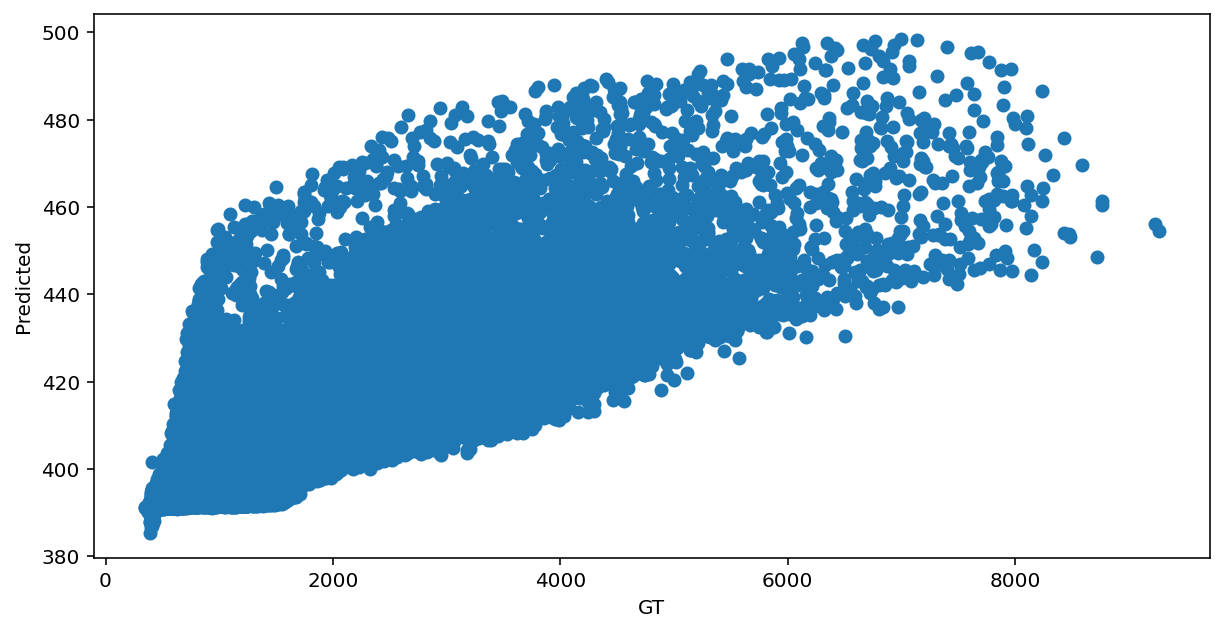

In [19]:
plt.figure(figsize=(10,5))
plt.scatter(y.flatten(), restored.flatten())
plt.xlabel("GT")
plt.ylabel("Predicted")

## **5.2. Assess predicted output**
---



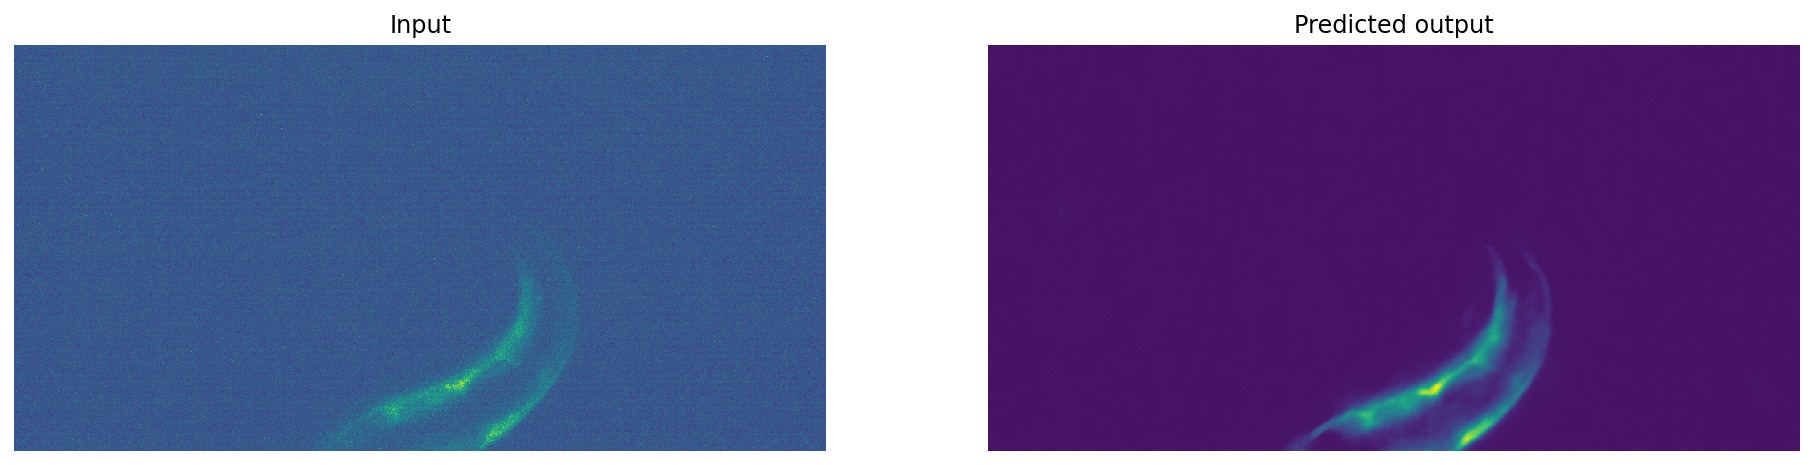

In [8]:
# @markdown ##Run this cell to display a randomly chosen input and its corresponding predicted output.

# This will display a randomly chosen dataset input and predicted output
random_choice = random.choice(os.listdir(Test_data_folder))
x = imread(Test_data_folder+"/"+random_choice)

os.chdir(Result_folder)
y = imread(Result_folder+"/"+random_choice)

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(x, interpolation='nearest')
plt.title('Input')

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(y, interpolation='nearest')
plt.title('Predicted output');


## **5.3. Download your predicted output**
---

<font size = 4>**Store your data** and ALL its results elsewhere by downloading it from Google Drive and after that clean the original folder tree (datasets, results, trained model etc.) if you plan to train or use new networks. Please note that notebook will otherwise **OVERWRITE** all files which have the same name.